In [12]:
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import *
import sys
import librosa
import time
from pathlib import Path
import cv2
#import IPython.display as ipd
import simpleaudio as sa

def plotaudio(y):
    plt.plot(y)
    plt.show()

def plot2im ( y ):
    fig=plt.figure()
    plt.plot(y)
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( h, w,4 )
    #get only BGR (opencv pattern)
    buf=buf[:,:,[3,2,1]]

    return buf

def nothing(val):
    pass
def viewFrame(num):
    if not play:
        cap.set(cv2.CAP_PROP_POS_FRAMES, num)
        ret, frame = cap.read()
        cv2.imshow('video',frame)

import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import *
import sys
import librosa
import time
from scipy.signal import medfilt
import simpleaudio as sa
import pandas as pd
import crepe
from scipy.io import wavfile


def video_note_split(vName,threshold=0.8, tune_thresh=0.3,dur_thresh=0.1, show_notes=False):
    """
    vName: string ending with .mp4 that contains the video with the notes
    creates a csv file cointaining the starting and ending of all notes
    """
    
    video = VideoFileClip(vName)
    audio = video.audio
    h,w=video.size
    fps=video.fps
    print('video size ',w,'x',h,', at ',fps,' fps.')
    t=audio.duration
    sr=audio.fps
    print('audio duration: ',t,', sampling rate: ',sr)
    y=audio.to_soundarray(fps=sr)

    y=librosa.core.to_mono(np.transpose(y))
    #y_harmonic, y_percussive = librosa.effects.hpss(y)
    time, frequency, confidence, activation = crepe.predict(y, sr, viterbi=True)
    mfr=medfilt(frequency,21)
    midi=69+12*np.log2(mfr/440)
    mcon=medfilt(confidence,21)
    if show_notes:
        plt.plot(time,midi)
        plt.plot(time,np.min(midi)+mcon*(np.max(midi)-np.min(midi)))
        plt.show()

    registeringNote=False
    notas = {'midi':[],'inicio':[],'fim':[],'duracao':[],'i':[],'j':[],'avg conf':[],'std dev':[]}
    notas = pd.DataFrame(notas)
    for i in range(time.shape[0]):
        if confidence[i]>threshold:
            if not registeringNote:
                registeringNote=True
                row=pd.DataFrame({'midi':[midi[i]],'inicio':[time[i]],'i':[i]})            
                notas=notas.append(row, ignore_index=True)
            else:
                pass
        else:
            if registeringNote:
                registeringNote=False
                notas.at[notas.index[-1],'j']=i
                notas.at[notas.index[-1],'fim']=time[i]
                notas.at[notas.index[-1],'duracao']=notas.at[notas.index[-1],'fim']-notas.at[notas.index[-1],'inicio']
                notas.at[notas.index[-1],'avg conf']=np.average(confidence[int(notas.at[notas.index[-1],'i']):i])
                #print(notas.tail(1))
                #note end
            else:
                pass
    #remove low duration notes
    indexLowDur = notas[ notas['duracao'] < dur_thresh ].index
    notas=notas.drop(indexLowDur , inplace=False)
    #remove out of tune notes
    for index, row in notas.iterrows():
        i=int(notas.at[index,'i'])
        j=int(notas.at[index,'j'])
        note=int(round(np.average(midi[i:j])))
        std = np.sqrt(np.average(abs(midi[i:j] - note)**2))#std deviation
        #print(np.abs(midi[i:j]-note)<tuneThresh)
        notesThatPassed=np.abs(midi[i:j]-note)<tune_thresh
        if not all(notesThatPassed):
            #remove that line         
            notas=notas.drop(index , inplace=False)
        else:
            notas.at[index,'midi']=note
            notas.at[index,'std dev']=std
    
    print("identifyed notes: ")
    print(notas)
    vName=vName.split('.')[0]
    notas.to_csv(vName+'.csv', index = False)
    return notas


def folder_note_split(instrument_name ,threshold=0.8, tune_thresh=0.3,dur_thresh=0.1):
    """
    folder: string containig a folder that contains .mp4 files
    """
    folder=Path('instruments')/Path(instrument_name)

    videos=[video_path for video_path in folder.iterdir() if video_path.exists() and video_path.suffix=='.mp4']
    dfs=[]
    for vid in videos:
        dfs.append(video_note_split(str(vid), threshold, tune_thresh, dur_thresh))
    df=pd.concat(dfs, keys=videos,names=[folder, 'Notes'])
    df.to_csv(Path(folder)/Path(instrument_name+'.csv'))
    df=df.reset_index(level=[folder])
    return df

#notas_flauta=folder_note_split('recorder',threshold=0.8, tune_thresh=0.6,dur_thresh=0.2)
#(notas_flauta['midi'].min(),notas_flauta['midi'].max())

In [76]:

from mido import MidiFile
import mido
import time
'''MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('key_signature', key='A', time=0),
    MetaMessage('set_tempo', tempo=500000, time=0),
    Message('control_change', channel=0, control=121, value=0, time=0),
    Message('program_change', channel=0, program=57, time=0),
    Message('control_change', channel=0, control=7, value=100, time=0),
    Message('control_change', channel=0, control=10, value=64, time=0),
    Message('control_change', channel=0, control=91, value=0, time=0),
    Message('control_change', channel=0, control=93, value=0, time=0),
    MetaMessage('midi_port', port=0, time=0),
    Message('note_on', channel=0, note=54, velocity=80, time=0),
    Message('note_on', channel=0, note=54, velocity=0, time=239),
    Message('note_on', channel=0, note=57, velocity=80, time=241),
    
    Message('note_on', channel=0, note=54, velocity=80, time=0),
    Message('note_on', channel=0, note=54, velocity=0, time=239),
    Message('note_on', channel=0, note=57, velocity=80, time=241),
    Message('note_on', channel=0, note=57, velocity=0, time=239),
    Message('note_on', channel=0, note=61, velocity=80, time=1),
    Message('note_on', channel=0, note=61, velocity=0, time=239),
    Message('note_on', channel=0, note=57, velocity=80, time=241),
    Message('note_on', channel=0, note=57, velocity=0, time=239),
    Message('note_on', channel=0, note=54, velocity=80, time=241),
    Message('note_on', channel=0, note=54, velocity=0, time=239),
    Message('note_on', channel=0, note=50, velocity=80, time=1),
    Message('note_on', channel=0, note=50, velocity=0, time=119),
    Message('note_on', channel=0, note=50, velocity=80, time=121),'''
def read_midi_tracks(filename,track_num=-1,dur_mult=1, transpose=0, verbose=False):
    """
    filename: string .mid
    track_num: number of the track, if 0, return all tracks
    creates and returns a song structure, with midi notes, start time and duration
    note: midi note
    velocity: sound loudness/amplitude/volume
    type 0 (single track): all messages are saved in one track
    type 1 (synchronous): all tracks start at the same time
    type 2 (asynchronous): each track is independent of the others

    """
    song=[]
    mid = MidiFile(filename)
    
    if verbose:
        print(mid.__dict__)
        print(mid.ticks_per_beat)
    if mid.type==0 or mid.type==1:
            
        for i, track in enumerate(mid.tracks):
            
            if verbose:
                print(f'Track {i}: {track.name}')        
            midiNotes=list()#[len(mid.tracks)][]
            startTimes=list()
            endTimes=list() 
            velocities=list()
            channel=[]
            mi=0
            cumulative_time=0.0
            for msg in track:            
                if not msg.is_meta:             
                    
                    if msg.type=='note_on' and msg.velocity!=0:
                        midiNotes.append(msg.note+transpose)
                        velocities.append(msg.velocity)
                        channel.append(msg.channel)
                        startTimes.append(cumulative_time)
                        cumulative_time+=mido.tick2second(msg.time,mid.ticks_per_beat,mido.bpm2tempo(mid.ticks_per_beat))*dur_mult               
                        endTimes.append(cumulative_time)
                        mi+=1
                    else:#if msg.type=='note_off' or msg.velocity==0:    
                        cumulative_time+=mido.tick2second(msg.time,mid.ticks_per_beat,mido.bpm2tempo(mid.ticks_per_beat))*dur_mult                
                    #else:
                    #    pass
            song.append({'midi':midiNotes,'start':startTimes,'end':endTimes,'velocity':velocities,'channel':channel})
    
    if track_num==-1:
        print('returning all tracks')
        return song
    else:
        print('returning track '+str(track_num))
        return song[track_num]

def print_msgs(filename='midis/Earth_gods_lyric.mid'):
    mid = MidiFile(filename)
    if mid.type==0 or mid.type==1:
        for i, track in enumerate(mid.tracks):
            for msg in track:  
                print(msg)          




#notas_musica=read_midi_tracks('bach_badinerie.mid',track_num=-1,dur_mult=2,transpose=7)
#print(notas_musica[1])
notas_musica=read_midi_tracks('midis/Earth_gods_lyric.mid',track_num=-1,dur_mult=2,transpose=7, verbose=True)
for v in notas_musica:
    for (n,s,e,v,c) in zip(v['midi'],v['start'],v['end'],v['velocity'],v['channel']):
        print(f'{n}:({s:.2f}:{e:.2f}),{v},{c}', end='___')
#min(notas_musica['midi']),max(notas_musica['midi'])

{'filename': 'midis/Earth_gods_lyric.mid', 'type': 0, 'ticks_per_beat': 192, 'charset': 'latin1', 'debug': False, 'clip': False, 'tracks': [MidiTrack([
  Message('control_change', channel=1, control=32, value=50, time=0),
  Message('control_change', channel=1, control=0, value=0, time=0),
  Message('program_change', channel=1, program=46, time=0),
  Message('control_change', channel=2, control=32, value=50, time=0),
  Message('control_change', channel=2, control=0, value=0, time=0),
  Message('program_change', channel=2, program=46, time=0),
  MetaMessage('track_name', name="Earth God's Lyric", time=0),
  MetaMessage('copyright', text='Composer:  Koji Kondo\rSequenced by:  Robert Harrington', time=0),
  MetaMessage('text', text='Legend of Zelda:  The Wind Waker', time=0),
  MetaMessage('set_tempo', tempo=750000, time=0),
  MetaMessage('time_signature', numerator=1, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
  MetaMessage('key_signature', key='D', time=0

In [77]:
def print_msgs(filename='midis/Earth_gods_lyric.mid'):
    mid = MidiFile(filename)
    if mid.type==0 or mid.type==1:
        for i, track in enumerate(mid.tracks):
            for msg in track:  
                print(msg) 
print_msgs()

control_change channel=1 control=32 value=50 time=0
control_change channel=1 control=0 value=0 time=0
program_change channel=1 program=46 time=0
control_change channel=2 control=32 value=50 time=0
control_change channel=2 control=0 value=0 time=0
program_change channel=2 program=46 time=0
MetaMessage('track_name', name="Earth God's Lyric", time=0)
MetaMessage('copyright', text='Composer:  Koji Kondo\rSequenced by:  Robert Harrington', time=0)
MetaMessage('text', text='Legend of Zelda:  The Wind Waker', time=0)
MetaMessage('set_tempo', tempo=750000, time=0)
MetaMessage('time_signature', numerator=1, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
MetaMessage('key_signature', key='D', time=0)
control_change channel=1 control=101 value=0 time=13
control_change channel=1 control=100 value=0 time=0
control_change channel=1 control=6 value=24 time=0
control_change channel=1 control=7 value=127 time=0
pitchwheel channel=1 pitch=0 time=0
control_change channel=1 cont

In [92]:
def interval_cross(a,b):
    #Checks if interval a crosses with interval b
    if a[1]>b[0] and a[0]<b[1]:
        return True
    return False
interval_cross((0,2),[2,3]),interval_cross((0,3),[1,2]),interval_cross((0,3),[2,4]),interval_cross((2,3),[0,2]), interval_cross((2,5),[1,3])





def break_track_voices(midi_track):
    voices=[]
    if len(midi_track)==0:
        return [midi_track]
    channels=list(set(midi_track['channel']))
    for ch in channels:
        track_channel={}
        ch_idxs=[i for i,c in enumerate(midi_track['channel']) if c==ch]
        track_channel['midi']=[midi_track['midi'][i] for i in ch_idxs]
        track_channel['start']=[midi_track['start'][i] for i in ch_idxs]
        track_channel['end']=[midi_track['end'][i] for i in ch_idxs]
        track_channel['velocity']=[midi_track['velocity'][i] for i in ch_idxs]
        track_channel['channel']=[midi_track['channel'][i] for i in ch_idxs]
        while len(track_channel['midi'])>0:
            idxs=[]
            new_voice={'midi':[],'start':[],'end':[],'velocity':[],'channel':[]}
            for i in range(len(track_channel['midi'])):#, (note, start_t, end_t) in enumerate(zip(midi_track['midi'],midi_track['start'],midi_track['end'])):
                
                if track_channel['start'][i]==track_channel['end'][i]:
                    pass#continue

                cross_with_someone=False
                for j in range(len(track_channel['midi'])):#j, (note_, start_t_, end_t_) in enumerate(zip(new_voice['midi'],new_voice['start'],new_voice['end'])):
                    if j>i:
                        if track_channel['start'][j]==track_channel['end'][j]:
                            pass#continue
                        if interval_cross((track_channel['start'][i],track_channel['end'][i]),(track_channel['start'][j],track_channel['end'][j])) and track_channel['velocity'][i]>0 and track_channel['velocity'][j]>0:                       
                            cross_with_someone=True
                            print((track_channel['start'][i],track_channel['end'][i]),(track_channel['start'][j],track_channel['end'][j]))
                        
                if not cross_with_someone:
                    idxs.append(i)
                    new_voice['midi'].append(track_channel['midi'][i])
                    new_voice['start'].append(track_channel['start'][i])
                    new_voice['end'].append(track_channel['end'][i])
                    new_voice['velocity'].append(track_channel['velocity'][i])
                    new_voice['channel'].append(track_channel['channel'][i])
                #print(i,cross_with_someone)
            voices.append(new_voice)
            print(idxs)
            track_channel['midi'] = [m for i, m in enumerate(track_channel['midi']) if i not in idxs]
            track_channel['start'] = [s for i, s in enumerate(track_channel['start']) if i not in idxs]
            track_channel['end'] = [e for i, e in enumerate(track_channel['end']) if i not in idxs]
            track_channel['velocity'] = [v for i, v in enumerate(track_channel['velocity']) if i not in idxs]
            track_channel['channel'] = [c for i, c in enumerate(track_channel['channel']) if i not in idxs]

        voices.append(track_channel)
    return voices

#notas_musica=read_midi_tracks('midis/sentimental piano2.mid',track_num=1,dur_mult=2,transpose=7, verbose=True)
notas_musica=read_midi_tracks('midis/Earth_gods_lyric.mid',track_num=0,dur_mult=2,transpose=7, verbose=False)
#print(len(notas_musica)[0])
#notas_musica=read_midi_tracks('bach_badinerini.mid',track_num=0,dur_mult=2,transpose=7, verbose=False)
voices=break_track_voices(notas_musica)
#print(voices)
#print(len(voices))
for v in voices:
    print('voice:')
    for (n,s,e,v,c) in zip(v['midi'],v['start'],v['end'],v['velocity'],v['channel']):
        print(f'{n}:({s:.3f}:{e:.3f}),{v},{c}', end='_')
#print(notas_musica)

returning track 0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
voice:
76:(0.042:0.042),76,1_76:(0.661:0.661),76,1_81:(1.077:1.077),76,1_85:(1.289:1.289),76,1_83:(1.706:1.706),76,1_81:(1.914:1.914),76,1_80:(2.327:2.327),76,1_81:(2.536:2.536),76,1_78:(2.952:2.952),76,1_74:(3.164:3.164),76,1_80:(3.581:3.581),76,1_76:(3.789:3.789),76,1_81:(3.997:3.997),76,1_78:(4.202:4.202),76,1_80:(4.411:4.411),76,1_76:(4.831:4.831),76,1_74:(5.039:5.039),76,1_81:(5.456:5.456),76,1_78:(5.664:5.664),76,1_80:(6.077:6.077),76,1_81:(6.286:6.286),76,1_83:(6.706:6.706),76,1_85:(6.914:6.914),76,1_81:(7.122:7.122),76,1_83:(7.331:7.331),76,1_76:(7.539:7.539),76,1_76:(8.161:8.161),76,1_81:(8.581:8.581),76,1_85:(8.789:8.789),76,1_83:(9.206:9.206),76,1_81:(9.414:9.414),76,1_80:(9.827:9.827),76,1_81:(10.036:10.036),76

In [10]:

import subprocess as sp
from moviepy.editor import *
import cv2
import moviepy.audio.fx.all as afx


def create_clip(instrumento, midi_track, save_name, dur_mult=1, imgshape='nochange'):
    """
    Source file: video(.mp4) from where i take the notes
    notas: csv with information of the notes of a source video, generated by func
    midi_track: list of midi notes, generated by func
    save_name: .mp4 string with the name to save the file
    create the file with the sequenced song
    imgshapes:nochange, square, portrait, landscape
    """
    #preparing
    notas=pd.read_csv(Path('instruments')/Path(instrumento)/Path(instrumento+'.csv'))
    
    instrument_col= [col for col in notas.columns if 'instruments' in col][0]
    files=notas[instrument_col].unique()

    source_vids={}
    for i, rows in notas.iterrows():
        
        if rows[instrument_col] not in source_vids:
            print(rows[instrument_col])
            vid=VideoFileClip(rows[instrument_col])
            source_vids[rows[instrument_col]]=vid
    
    
    clips=[]
    for i in range(len(midi_track['midi'])):
        this_note=notas.loc[notas['midi'] == midi_track['midi'][i]]#select with correct midi value
        dur=(midi_track['end'][i]-midi_track['start'][i])*dur_mult
        if dur==0:
            continue
        if len(this_note)==0:
            print("missing note of midi "+str(midi_track['midi'][i])+", and duration of at least "+str(dur))
            continue
        this_note=this_note.loc[this_note['duracao'] >= dur]#select with the right duration
        if len(this_note)==0:
            print("missing note of midi "+str(midi_track['midi'][i])+", and duration of at least "+str(dur))
            continue
        this_note=this_note[this_note['std dev'] == this_note['std dev'].min()]#nota mais afinada 
        if len(this_note)==0:
            print("missing note of midi "+str(midi_track['midi'][i])+", and duration of at least "+str(dur))
            continue
        print("adding note: ")
        print(this_note)
        startime=this_note.at[this_note.index[-1],'inicio']*dur_mult
        endtime=startime+dur

               
            


        video=source_vids[this_note.at[this_note.index[-1],instrument_col]]
        noteClip=video.subclip(startime,endtime)#this_note['inicio'],this_note['inicio']+dur)
        noteClip=noteClip.set_start(midi_track['start'][i])
        #noteClip.audio=fx.audio_fadeout(fx.audio_fadein(noteClip, 0.01), 0.01)
        noteClip=afx.audio_fadeout(afx.audio_fadein(noteClip, 0.01), 0.01)  
        if imgshape!='nochange':
            center=avg_face_center(this_note.at[this_note.index[-1],instrument_col],
                                (startime,endtime), show=False)
            if imgshape=='square':
                pass
                noteClip=noteClip.set_position((-960+540,0))
            if imgshape=='portrait':
                noteClip=noteClip.set_position((540-center[1],0))
            if imgshape=='landscape':
                noteClip=noteClip.set_position((960-center[1],0))


        clips.append(noteClip)
    if imgshape=='nochange':
        size=noteClip.size
    if imgshape=='square':
        size=(1080,1080)
    if imgshape=='portrait':
        size=(1080,1920)
    if imgshape=='landscape':
        size=(1920,1080)
    
    print(len(clips))
    print(midi_track)
    cc = CompositeVideoClip(clips,size=size)
    
    cc.write_videofile(save_name)

#create_clip('recorder',notas_musica,'bach_flauta.mp4',track_face=False)


In [30]:
#folder_note_split('trombone',threshold=0.8, tune_thresh=0.6,dur_thresh=0.2)
import matplotlib.pyplot as plt
import statistics
def avg_face_center(video, time,show=False):
    """
    video: mp4 file
    time: tuple(start, end)
    """
    clip = VideoFileClip(video)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')    
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    all_faces=[]
    print(time[0],time[1])
    for t in np.arange(time[0],time[1],1/clip.fps):
        frame = clip.get_frame(t)
        try:
            frame = clip.get_frame(t)
        except:
            continue
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        if show:
            cv2.imshow('test',cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            cv2.waitKey(33)
        if len(faces)>0:
            all_faces.append(faces[0])
    #print("FACES: ",all_faces)
    all_x=[x for (x,y,h,w) in all_faces]
    all_y=[y for (x,y,h,w) in all_faces]
    all_h=[h for (x,y,h,w) in all_faces]
    all_w=[w for (x,y,h,w) in all_faces]
    if len(all_faces)==0:
        return (frame.shape[0]//2,frame.shape[1]//2)
    median_rec=(int(statistics.median(all_x)),int(statistics.median(all_y)),int(statistics.median(all_h)),int(statistics.median(all_w)))
    if show:
        cv2.rectangle(frame,(median_rec[0],median_rec[1]),(median_rec[0]+median_rec[2],median_rec[1]+median_rec[3]),(0,0,0),2)
        cv2.imshow('test',cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        plt.imshow(frame)
        plt.show()
    return ((median_rec[0]+median_rec[2])//2,(median_rec[1]+median_rec[3])//2)

#avg_face_center('instruments/recorder/20220416_161109.mp4',(3,4),show=True)
#avg_face_center('instruments/recorder/20220416_160546.mp4',(3,4),show=True)
#avg_face_center('instruments/recorder/20220417_151406.mp4',(3,4),show=True)
avg_face_center('instruments/recorder/flauta.mp4',(3,4),show=True)


3 4


(540, 960)

In [38]:
#create_clip('flauta.mp4','flauta.csv',notas,'bach.mp4')
def montage(instrumento='trombone', midi_file='bach_badinerie.mid',track_num=1,imgshape='square',dur_mult=1,threshold=0.8, tune_thresh=0.6,dur_thresh=0.2):
    instrument_notes=Path('instruments')/Path(instrumento)/Path(instrumento+'.csv')
    if instrument_notes.exists():
        notas=pd.read_csv(Path('instruments')/Path(instrumento)/Path(instrumento+'.csv'))
        print(f"{notas} exists")
    else:
        print(f"{notas} do not exists, creating")
        notas=folder_note_split(instrumento,threshold=threshold, tune_thresh=tune_thresh,dur_thresh=dur_thresh)

    notas_musica_=read_midi_tracks(midi_file,track_num=track_num,dur_mult=dur_mult)

    if isinstance(notas_musica_, list):
        notas_musica_=notas_musica_[0]
    
    ins_notes=[ int(n) for n in notas['midi'].tolist()]
    ins_notes=list(set(ins_notes))

    song_notes=list(set(notas_musica_['midi']))
    song_notes=notas_musica_['midi']

    transposes =[[i,-i] for i in range(24)]
    transposes = [item for sublist in transposes for item in sublist]
    higher_num_notes=0
    transpose_to=0
    for t in transposes:
        trans_song_notes=[x+t for x in song_notes]
        n=len([i for i in trans_song_notes if i in ins_notes ])
        if n>higher_num_notes:
            higher_num_notes=n
            transpose_to=t
            print([i for i in ins_notes if i in trans_song_notes ])
            print(f'Transposing: {t}, gives: {n}/{len(song_notes)} notes')
   
    print(f'Transposing: {transpose_to}')
    save_name=f"{midi_file[:-4]}_{instrumento}.mp4"
    notas_musica_=read_midi_tracks(midi_file,track_num=track_num,dur_mult=dur_mult, transpose=transpose_to)    
    if isinstance(notas_musica_, list):
        notas_musica_=notas_musica_[0]
    create_clip(instrumento,notas_musica_,save_name,imgshape=imgshape)

#montage(instrumento='trombone', midi_file='bach_badinerie.mid')
#montage(instrumento='recorder', midi_file='bach_badinerie.mid')

In [39]:
#montage(instrumento='recorder', midi_file=str(Path('midis')/Path('BTS_DNA_Flute_Score.mid')))
montage(instrumento='recorder', midi_file='bach_badinerini.mid',track_num=0,dur_mult=4,imgshape='nochange')


                        instruments\recorder  Notes  midi  inicio    fim  \
0   instruments\recorder\20220416_160251.mp4      1  73.0    4.52   6.59   
1   instruments\recorder\20220416_160251.mp4      3  74.0    6.73   8.58   
2   instruments\recorder\20220416_160251.mp4      4  75.0    8.86  10.38   
3   instruments\recorder\20220416_160251.mp4      9  73.0   15.25  17.11   
4   instruments\recorder\20220416_160251.mp4     10  76.0   17.56  18.00   
..                                       ...    ...   ...     ...    ...   
95           instruments\recorder\flauta.mp4     21  74.0    5.77   5.99   
96           instruments\recorder\flauta.mp4     23  72.0    6.09   6.29   
97           instruments\recorder\flauta.mp4     26  76.0    6.60   6.81   
98           instruments\recorder\flauta.mp4     27  77.0    6.83   7.18   
99           instruments\recorder\flauta.mp4     28  77.0    7.19   7.45   

    duracao       i       j  avg conf   std dev  
0      2.07   452.0   659.0  0.913252

MoviePy - Done.
Moviepy - Writing video bach_badinerini_recorder.mp4



Moviepy - Done !
Moviepy - video ready bach_badinerini_recorder.mp4


In [53]:
montage(instrumento='recorder', midi_file='midis/Mii Channel - Duo Trombone.mid',track_num=0,dur_mult=4,imgshape='nochange')


                        instruments\recorder  Notes  midi  inicio    fim  \
0   instruments\recorder\20220416_160251.mp4      1  73.0    4.52   6.59   
1   instruments\recorder\20220416_160251.mp4      3  74.0    6.73   8.58   
2   instruments\recorder\20220416_160251.mp4      4  75.0    8.86  10.38   
3   instruments\recorder\20220416_160251.mp4      9  73.0   15.25  17.11   
4   instruments\recorder\20220416_160251.mp4     10  76.0   17.56  18.00   
..                                       ...    ...   ...     ...    ...   
95           instruments\recorder\flauta.mp4     21  74.0    5.77   5.99   
96           instruments\recorder\flauta.mp4     23  72.0    6.09   6.29   
97           instruments\recorder\flauta.mp4     26  76.0    6.60   6.81   
98           instruments\recorder\flauta.mp4     27  77.0    6.83   7.18   
99           instruments\recorder\flauta.mp4     28  77.0    7.19   7.45   

    duracao       i       j  avg conf   std dev  
0      2.07   452.0   659.0  0.913252

MoviePy - Done.
Moviepy - Writing video midis/Mii Channel - Duo Trombone_recorder.mp4



Moviepy - Done !
Moviepy - video ready midis/Mii Channel - Duo Trombone_recorder.mp4


In [56]:

mid=read_midi_tracks('midis/Mii Channel - Duo Trombone.mid',track_num=-1,dur_mult=1, transpose=0)
#mid=read_midi_tracks('bach_badinerini.mid',track_num=-1,dur_mult=1, transpose=0)

#print(mid[0])
print(mid[1])


MidiFile(type=1, ticks_per_beat=480, tracks=[
  MidiTrack([
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('key_signature', key='A', time=0),
    MetaMessage('set_tempo', tempo=500000, time=0),
    Message('control_change', channel=0, control=121, value=0, time=0),
    Message('program_change', channel=0, program=57, time=0),
    Message('control_change', channel=0, control=7, value=100, time=0),
    Message('control_change', channel=0, control=10, value=64, time=0),
    Message('control_change', channel=0, control=91, value=0, time=0),
    Message('control_change', channel=0, control=93, value=0, time=0),
    MetaMessage('midi_port', port=0, time=0),
    Message('note_on', channel=0, note=54, velocity=80, time=0),
    Message('note_on', channel=0, note=54, velocity=0, time=239),
    Message('note_on', channel=0, note=57, velocity=80, time=241),
    Message('note_on', channel=0, note=57, velocit

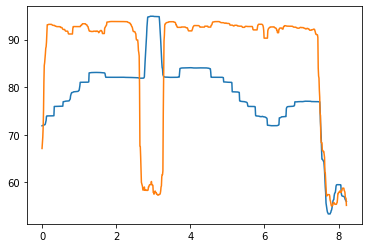

Empty DataFrame
Columns: [midi, inicio, fim, duracao, i, j, avg conf, std dev]
Index: []
         midi  inicio   fim  duracao      i      j  avg conf  std dev
0   71.979317    0.03  0.04     0.01    3.0    4.0  0.838114      NaN
1   72.077291    0.06  0.09     0.03    6.0    9.0  0.841687      NaN
2   73.960417    0.13  0.32     0.19   13.0   32.0  0.954725      NaN
3   75.949025    0.34  0.56     0.22   34.0   56.0  0.937632      NaN
4   76.951060    0.58  0.74     0.16   58.0   74.0  0.928454      NaN
5   78.909707    0.83  0.98     0.15   83.0   98.0  0.949583      NaN
6   81.019309    1.03  1.23     0.20  103.0  123.0  0.948998      NaN
7   81.048548    1.24  1.26     0.02  124.0  126.0  0.852781      NaN
8   83.004155    1.28  1.70     0.42  128.0  170.0  0.919415      NaN
9   82.074834    1.73  2.45     0.72  173.0  245.0  0.968288      NaN
10  82.008566    2.47  2.57     0.10  247.0  257.0  0.899117      NaN
11  81.974267    2.58  2.63     0.05  258.0  263.0  0.898984      NaN
1

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import medfilt
mfr=medfilt(frequency,21)
midi=69+12*np.log2(mfr/440)
mcon=medfilt(confidence,21)
plt.plot(time,midi)
plt.plot(time,np.min(midi)+mcon*(np.max(midi)-np.min(midi)))
plt.show()

import pandas as pd
threshold=0.8
tune_thresh=0.3#in midi
registeringNote=False
notas = {'midi':[],'inicio':[],'fim':[],'duracao':[],'i':[],'j':[],'avg conf':[],'std dev':[]}
notas = pd.DataFrame(notas)
print(notas)
for i in range(time.shape[0]):
    if confidence[i]>threshold:
        if not registeringNote:
            registeringNote=True
            row=pd.DataFrame({'midi':[midi[i]],'inicio':[time[i]],'i':[i]})            
            #print(row)
            notas=notas.append(row, ignore_index=True)
            #print(notas.tail(1))

            #note start
        else:
            pass
    else:
        if registeringNote:
            registeringNote=False
            notas.at[notas.index[-1],'j']=i
            notas.at[notas.index[-1],'fim']=time[i]
            notas.at[notas.index[-1],'duracao']=notas.at[notas.index[-1],'fim']-notas.at[notas.index[-1],'inicio']
            notas.at[notas.index[-1],'avg conf']=np.average(confidence[int(notas.at[notas.index[-1],'i']):i])
            #print(notas.tail(1))
            #note end
        else:
            pass
print(notas)
#demove low duration notes
durThresh=0.1
indexLowDur = notas[ notas['duracao'] < durThresh ].index
notas=notas.drop(indexLowDur , inplace=False)
print(notas)
#remove out of tune notes
tuneThresh=0.3
for index, row in notas.iterrows():
    i=int(notas.at[index,'i'])
    j=int(notas.at[index,'j'])
    note=int(round(np.average(midi[i:j])))
    std = np.sqrt(np.average(abs(midi[i:j] - note)**2))#std deviation
    #print(np.abs(midi[i:j]-note)<tuneThresh)
    notesThatPassed=np.abs(midi[i:j]-note)<tuneThresh
    if not all(notesThatPassed):
        #remove that line         
        notas=notas.drop(index , inplace=False)
    else:
        notas.at[index,'midi']=note
        notas.at[index,'std dev']=std

print(notas)
notas.to_csv(r'flauta.csv', index = False)


In [ ]:
!pip install moviepy --upgrade
import subprocess as sp
from moviepy.editor import *
import os
recorder = VideoFileClip("flauta.mp4")

song_midi={'midi':[72, 72, 74, 72, 77, 76, 60],'start':[0.0,0.05,0.1,0.3,0.4,0.5,0.7],'end':[0.05,0.1,0.3,0.4,0.5,0.7,0.8]}
#song_midi={'midi':[60, 60, 62, 60, 65, 64],'start':[0.0,0.05,0.1,0.3,0.4,0.5],'end':[0.05,0.1,0.3,0.4,0.5,0.7]}


clips=[]
for i in range(len(song_midi['midi'])):
    this_note=notas.loc[notas['midi'] == song_midi['midi'][i]]#select with correct midi value
    ok=False
    if len(this_note)>0:
        ok=True
    dur=song_midi['end'][i]-song_midi['start'][i]
    this_note=this_note.loc[this_note['duracao'] >= dur]#select with the right duration
    if len(this_note)>0:
        ok=True
    this_note=this_note[this_note['std dev'] == this_note['std dev'].min()]#nota mais afinada 
    if len(this_note)>0:
        ok=True
    if not ok:
        print("missing note of midi "+str(song_midi['midi'][i])+", and duration of at least "+str(dur))
        continue
    startime=this_note.at[this_note.index[-1],'inicio']
    endtime=startime+dur 
    noteClip=recorder.subclip(startime,endtime)#this_note['inicio'],this_note['inicio']+dur)
    noteClip=noteClip.set_start(song_midi['start'][i])
    clips.append(noteClip)
    print("adding note: ")
    print(this_note)

cc = CompositeVideoClip(clips)
cc.write_gif("test.gif")
#cc.set_duration(0.5).write_videofile("happytest.mp4")
cc.write_videofile("happytest.mp4")





adding note: 
    midi  inicio   fim  duracao      i      j  avg conf   std dev
23  72.0    6.09  6.29      0.2  609.0  629.0  0.939434  0.077071
adding note: 
    midi  inicio   fim  duracao      i      j  avg conf   std dev
23  72.0    6.09  6.29      0.2  609.0  629.0  0.939434  0.077071
adding note: 
    midi  inicio   fim  duracao      i      j  avg conf   std dev
21  74.0    5.77  5.99     0.22  577.0  599.0  0.951404  0.143126
adding note: 
    midi  inicio   fim  duracao      i      j  avg conf   std dev
23  72.0    6.09  6.29      0.2  609.0  629.0  0.939434  0.077071
adding note: 
    midi  inicio   fim  duracao      i      j  avg conf   std dev
28  77.0    7.19  7.45     0.26  719.0  745.0  0.921512  0.037742
adding note: 
   midi  inicio   fim  duracao     i     j  avg conf   std dev
3  76.0    0.34  0.56     0.22  34.0  56.0  0.937632  0.035463
missing note of midi 60, and duration of at least 0.10000000000000009
MoviePy - Building file test.gif with imageio.


Moviepy - Building video happytest.mp4.
MoviePy - Writing audio in happytestTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video happytest.mp4



Moviepy - Done !
Moviepy - video ready happytest.mp4


In [ ]:

from mido import MidiFile
import mido
import time
mid = MidiFile('bach_badinerie.mid')
print(len(mid.tracks))
song=[]
print(mid)
print(mid.ticks_per_beat)
if mid.type==1:
    for i, track in enumerate(mid.tracks):
        print('Track {}: {}'.format(i, track.name))        
        midiNotes=list()#[len(mid.tracks)][]
        startTimes=list()
        endTimes=list() 
        mi=0
        cumulative_time=0
        for msg in track:            
            if not msg.is_meta:                
                if msg.type=='note_on':
                    midiNotes.append(msg.note)
                    startTimes.append(cumulative_time)
                    cumulative_time+=mido.tick2second(msg.time,mid.ticks_per_beat,mido.bpm2tempo(mid.ticks_per_beat))                
                    endTimes.append(cumulative_time)
                    mi+=1
                else:    
                    cumulative_time+=mido.tick2second(msg.time,mid.ticks_per_beat,mido.bpm2tempo(mid.ticks_per_beat))                
        song.append({'midi':midiNotes,'start':startTimes,'end':endTimes})
#print(song)
#print(song[1]['midi'][0])
print(song[1])


3
MidiFile(type=1, ticks_per_beat=256, tracks=[
  MidiTrack([
    MetaMessage('track_name', name='J.S.Bach', time=0),
    MetaMessage('text', text='Badinerie', time=0),
    MetaMessage('time_signature', numerator=2, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('key_signature', key='Bm', time=0),
    MetaMessage('set_tempo', tempo=600000, time=0),
    MetaMessage('key_signature', key='Bm', time=256),
    MetaMessage('end_of_track', time=1)]),
  MidiTrack([
    Message('control_change', channel=2, control=121, value=0, time=256),
    Message('control_change', channel=2, control=64, value=0, time=0),
    Message('control_change', channel=2, control=91, value=52, time=0),
    Message('control_change', channel=2, control=10, value=70, time=0),
    Message('control_change', channel=2, control=7, value=95, time=0),
    Message('program_change', channel=2, program=73, time=0),
    MetaMessage('track_name', name='Flute', time=0),
    Message('note_

In [ ]:
import subprocess as sp
from moviepy.editor import *
import os
recorder = VideoFileClip("flauta.mp4")
song_midi=song[1]

clips=[]
for i in range(len(song_midi['midi'])//2):
    this_note=notas.loc[notas['midi'] == song_midi['midi'][i]]#select with correct midi value
    ok=False
    if len(this_note)==0:
        print("missing note of midi "+str(song_midi['midi'][i])+", and duration of at least "+str(dur))
        continue
    dur=song_midi['end'][i]-song_midi['start'][i]
    this_note=this_note.loc[this_note['duracao'] >= dur]#select with the right duration
    if len(this_note)==0:
        print("missing note of midi "+str(song_midi['midi'][i])+", and duration of at least "+str(dur))
        continue
    this_note=this_note[this_note['std dev'] == this_note['std dev'].min()]#nota mais afinada 
    if len(this_note)==0:
        print("missing note of midi "+str(song_midi['midi'][i])+", and duration of at least "+str(dur))
        continue
    print("adding note: ")
    print(this_note)
    startime=this_note.at[this_note.index[-1],'inicio']
    endtime=startime+dur 
    #recorder.write_videofile('test.mp4')
    noteClip=recorder.subclip(startime,endtime)#this_note['inicio'],this_note['inicio']+dur)
    noteClip=noteClip.set_start(song_midi['start'][i])
    clips.append(noteClip)
    

cc = CompositeVideoClip(clips)
#cc.write_gif("test.gif")
#cc.set_duration(0.5).write_videofile("happytest.mp4")
cc.write_videofile("bach.mp4")


adding note: 
   midi  inicio  fim  duracao      i      j  avg conf   std dev
8  83.0    1.28  1.7     0.42  128.0  170.0  0.919415  0.068134
adding note: 
   midi  inicio  fim  duracao      i      j  avg conf   std dev
8  83.0    1.28  1.7     0.42  128.0  170.0  0.919415  0.068134
missing note of midi 86, and duration of at least 0.1171875
missing note of midi 86, and duration of at least 0.1171875
adding note: 
   midi  inicio  fim  duracao      i      j  avg conf   std dev
8  83.0    1.28  1.7     0.42  128.0  170.0  0.919415  0.068134
adding note: 
   midi  inicio  fim  duracao      i      j  avg conf   std dev
8  83.0    1.28  1.7     0.42  128.0  170.0  0.919415  0.068134
missing note of midi 78, and duration of at least 0.05859375
missing note of midi 78, and duration of at least 0.05859375
adding note: 
   midi  inicio  fim  duracao      i      j  avg conf   std dev
8  83.0    1.28  1.7     0.42  128.0  170.0  0.919415  0.068134
adding note: 
   midi  inicio  fim  duracao     

MoviePy - Done.
Moviepy - Writing video bach.mp4



Moviepy - Done !
Moviepy - video ready bach.mp4


In [ ]:

from mido import MidiFile
import mido
import time

def read_midi_tracks(filename,track_num=0):
    """
    filename: string .mid
    track_num: number of the track, if 0, return all tracks
    """
    mid = MidiFile(filename)
    if mid.type==1:
        for i, track in enumerate(mid.tracks):
            print('Track {}: {}'.format(i, track.name))        
            midiNotes=list()#[len(mid.tracks)][]
            startTimes=list()
            endTimes=list() 
            mi=0
            cumulative_time=0
            for msg in track:            
                if not msg.is_meta:                
                    if msg.type=='note_on':
                        midiNotes.append(msg.note)
                        startTimes.append(cumulative_time)
                        cumulative_time+=mido.tick2second(msg.time,mid.ticks_per_beat,mido.bpm2tempo(mid.ticks_per_beat))                
                        endTimes.append(cumulative_time)
                        mi+=1
                    else:    
                        cumulative_time+=mido.tick2second(msg.time,mid.ticks_per_beat,mido.bpm2tempo(mid.ticks_per_beat))                
            song.append({'midi':midiNotes,'start':startTimes,'end':endTimes})
    if track_num==0:
        return song
    else:
        print(track_num)
        return song[track_num]

import subprocess as sp
from moviepy.editor import *
import os

def create_clip(source_file,notas,song_midi,save_name):
    """
    Source file: video(.mp4) from where i take the notes
    notas: csv with information of the notes of a source video, generated by func
    midi: list of midi notes, generated by func
    save_name: .mp4 string with the name to save the file
    """
    source_vid=VideoFileClip(source_file)

    clips=[]
    for i in range(len(midi['midi'])//2):
        this_note=notas.loc[notas['midi'] == song_midi['midi'][i]]#select with correct midi value
        
        if len(this_note)==0:
            print("missing note of midi "+str(song_midi['midi'][i])+", and duration of at least "+str(dur))
            continue
        dur=song_midi['end'][i]-song_midi['start'][i]
        this_note=this_note.loc[this_note['duracao'] >= dur]#select with the right duration
        if len(this_note)==0:
            print("missing note of midi "+str(song_midi['midi'][i])+", and duration of at least "+str(dur))
            continue
        this_note=this_note[this_note['std dev'] == this_note['std dev'].min()]#nota mais afinada 
        if len(this_note)==0:
            print("missing note of midi "+str(song_midi['midi'][i])+", and duration of at least "+str(dur))
            continue
        print("adding note: ")
        print(this_note)
        startime=this_note.at[this_note.index[-1],'inicio']
        endtime=startime+dur 
        noteClip=source_vid.subclip(startime,endtime)#this_note['inicio'],this_note['inicio']+dur)
        noteClip=noteClip.set_start(song_midi['start'][i])
        clips.append(noteClip)


    cc = CompositeVideoClip(clips)
    cc.write_videofile(save_name)


In [ ]:

theCupSong = TextClip('Happy birthday',
    fontsize=50,
    font="Ubuntu-Regular",
    color = 'white')\
    .set_pos(('center', 0.24*H))
editedby = TextClip('Edited by Jonathan Alis',
    fontsize=28,
    font="Ubuntu-Regular",
    color = 'gray')\
    .set_pos(('center', 0.58*H))
titleScreen = CompositeVideoClip([theCupSong, editedby],
    size = (W,H))\
    .set_duration(3)\
    .fadeout(0.5)

print(midiNote)
port=mido.open_output()
for msg in mid:
    time.sleep(msg.time)
    if not msg.is_meta:
        port.send(msg)



OSError: MoviePy Error: creation of None failed because of the following error:

[WinError 2] O sistema não pode encontrar o arquivo especificado.

.This error can be due to the fact that ImageMagick is not installed on your computer, or (for Windows users) that you didn't specify the path to the ImageMagick binary in file conf.py, or that the path you specified is incorrect

In [ ]:
from moviepy.editor import *

# UKULELE CLIP, OBTAINED BY CUTTING AND CROPPING
# RAW FOOTAGE

ukulele = VideoFileClip("../../videos/moi_ukulele.MOV", audio=False).\
               subclip(60+33, 60+50).\
               crop(486, 180, 1196, 570)

w,h = moviesize = ukulele.size

# THE PIANO FOOTAGE IS DOWNSIZED, HAS A WHITE MARGIN, IS
# IN THE BOTTOM RIGHT CORNER 

piano = (VideoFileClip("../../videos/douceamb.mp4",audio=False).
         subclip(30,50).
         resize((w/3,h/3)).    # one third of the total screen
         margin( 6,color=(255,255,255)).  #white margin
         margin( bottom=20, right=20, opacity=0). # transparent
         set_pos(('right','bottom')) )



# A CLIP WITH A TEXT AND A BLACK SEMI-OPAQUE BACKGROUND

txt = TextClip("V. Zulkoninov - Ukulele Sonata", font='Amiri-regular',
	               color='white',fontsize=24)

txt_col = txt.on_color(size=(ukulele.w + txt.w,txt.h-10),
                  color=(0,0,0), pos=(6,'center'), col_opacity=0.6)


# THE TEXT CLIP IS ANIMATED.
# I am *NOT* explaining the formula, understands who can/want.
txt_mov = txt_col.set_pos( lambda t: (max(w/30,int(w-0.5*w*t)),
                                  max(5*h/6,int(100*t))) )



# FINAL ASSEMBLY
final = CompositeVideoClip([ukulele,txt_mov,piano])
final.subclip(0,5).write_videofile("../../ukulele.avi",fps=24,codec='libx264')




from moviepy.editor import VideoFileClip, clips_array, vfx
clip1 = VideoFileClip("myvideo.mp4").margin(10) # add 10px contour
clip2 = clip1.fx( vfx.mirror_x)
clip3 = clip1.fx( vfx.mirror_y)
clip4 = clip1.resize(0.60) # downsize 60%
final_clip = clips_array([[clip1, clip2],
                          [clip3, clip4]])
#final_clip.resize(width=480).write_videofile("my_stack.mp4")



import gizeh
import moviepy.editor as mpy

def make_frame(t):
    surface = gizeh.Surface(128,128) # width, height
    radius = W*(1+ (t*(2-t))**2 )/6 # the radius varies over time
    circle = gizeh.circle(radius, xy = (64,64), fill=(1,0,0))
    circle.draw(surface)
    return surface.get_npimage() # returns a 8-bit RGB array

clip = mpy.VideoClip(make_frame, duration=2) # 2 seconds
clip.write_gif("circle.gif",fps=15)